# Tutorial 7: The Transit Light Source Effect (TLSE)

**Author:** Hannu Parviainen <br>
**Edited:** 5 February 2026

This notebook explains the Transit Light Source Effect (TLSE) and demonstrates how to model it in ExoIris. TLSE is a systematic effect that can bias transmission spectra when the stellar surface contains heterogeneities (spots and faculae) that the planet does *not* occult during transit.

**Prerequisites:** You should be familiar with basic ExoIris usage (see Tutorial 1) and spot crossing modeling (see Tutorial 6).

**In this tutorial, you will learn:**

1. The physics behind TLSE and why it matters
2. How TLSE differs from spot crossings
3. When to include TLSE in your analysis
4. How to configure and fit TLSE parameters in ExoIris
5. How to interpret TLSE results

In [1]:
%run ../setup_multiprocessing.py

In [41]:
from multiprocessing import Pool
from numpy import concatenate, linspace, array
from matplotlib.pyplot import subplots, rc
import astropy.io.fits as pf

from exoiris import ExoIris, TSData, load_model
from exoiris.ephemeris import Ephemeris

rc('figure', figsize=(12,4))

## Understanding the Transit Light Source Effect

### The Problem: Stellar Heterogeneity

Stars are not uniform disks. Their surfaces contain:

- **Spots:** Cooler regions (~500-1500 K below photospheric temperature) that appear darker
- **Faculae:** Hotter regions (~100-300 K above photospheric temperature) that appear brighter

These heterogeneities affect transmission spectroscopy in two distinct ways:

### 1. Spot Crossings (Occulted Features)

When the planet crosses *over* a spot or facula during transit, we see a characteristic bump or dip in the light curve. This is what Tutorial 6 covers.

### 2. Transit Light Source Effect (Unocculted Features)

TLSE occurs because of spots and faculae that the planet does *not* cross. These unocculted features change the **reference flux level** against which we measure the transit depth.

**The key insight:** During transit, we compare the flux blocked by the planet to the total stellar flux. If the visible stellar disk has spots (darker regions) that the planet doesn't cross, the total flux is lower than it would be for a spotless star, but the planet still blocks the same amount of light from the transit chord. This makes the *apparent* transit depth larger than it should be.

### The TLSE Correction

The observed transit depth $\delta_{\rm obs}$ relates to the true transit depth $\delta_{\rm true}$ through:

$$\delta_{\rm obs}(\lambda) = \delta_{\rm true}(\lambda) \times \epsilon(\lambda)$$

where the TLSE correction factor $\epsilon(\lambda)$ is:

$$\epsilon(\lambda) = \frac{1}{1 - f_{\rm spot}\left(1 - \frac{F_{\rm spot}(\lambda)}{F_{\rm phot}(\lambda)}\right) - f_{\rm fac}\left(1 - \frac{F_{\rm fac}(\lambda)}{F_{\rm phot}(\lambda)}\right)}$$

where:
- $f_{\rm spot}$, $f_{\rm fac}$ are the area fractions covered by unocculted spots and faculae
- $F_{\rm spot}(\lambda)$, $F_{\rm fac}(\lambda)$, $F_{\rm phot}(\lambda)$ are the stellar spectra at spot, faculae, and photospheric temperatures

**Key effects:**
- **Spots** ($T_{\rm spot} < T_{\rm phot}$): $\epsilon > 1$ → transit appears **deeper** than true
- **Faculae** ($T_{\rm fac} > T_{\rm phot}$): $\epsilon < 1$ → transit appears **shallower** than true
- The effect is **wavelength-dependent** because spot/faculae contrast varies with wavelength

### TLSE vs. Spot Crossings: Key Differences

| Aspect | Spot Crossing | TLSE |
|--------|--------------|------|
| **Cause** | Planet crosses over a spot | Spots exist that planet doesn't cross |
| **Light curve signature** | Bump during transit | No distinctive signature |
| **Effect on spectrum** | Can be removed by modeling the bump | Biases all wavelengths systematically |
| **Detection** | Visible in light curve | Requires independent constraints or modeling |
| **Time dependence** | Changes from transit to transit | Slowly varies with stellar rotation |

**Important:** TLSE is insidious because it produces no obvious signature in the light curve. The only way to account for it is through modeling with physically-motivated priors.

## When to Include TLSE

Consider including TLSE in your analysis when:

1. **The host star is known to be active** (has spots, shows rotational modulation)
2. **You observe spot crossings** - if spots are being crossed, there are likely unocculted spots too
3. **Multiple epochs show different baseline levels** at different wavelengths
4. **High-precision transmission spectra** where systematic biases at the ~100 ppm level matter
5. **Comparing transmission spectra from different epochs** that may have different spot coverage

You may skip TLSE when:

1. The host star is quiet (no detected activity)
2. The expected effect is smaller than your measurement uncertainties
3. You're doing a quick exploratory analysis

## Practical Example: HAT-P-18b with TLSE

We'll use the same HAT-P-18b JWST NIRISS data from Tutorial 6. Since we already know this system has a spot crossing, it's reasonable to assume there may be additional unocculted spots affecting the baseline.

In [6]:
ephemeris = Ephemeris(59743.352, 5.508029, 0.12)

In [18]:
with pf.open('data/hat-p-18b-2022-06-niriss-o1.fits') as hdul:
    d1 = TSData.import_fits('NIRISS-O1', hdul)
    d1.mask_transit(ephemeris=ephemeris)
    d1.estimate_average_uncertainties()
    d1.n_baseline = 1

with pf.open('data/hat-p-18b-2022-06-niriss-o2.fits') as hdul:
    d2 = TSData.import_fits('NIRISS-O2', hdul)
    d2.mask_transit(ephemeris=ephemeris)
    d2.estimate_average_uncertainties()
    d2.n_baseline = 1

d2 = d2.crop_wavelength(0.6, 0.84)
d = d2 + d1

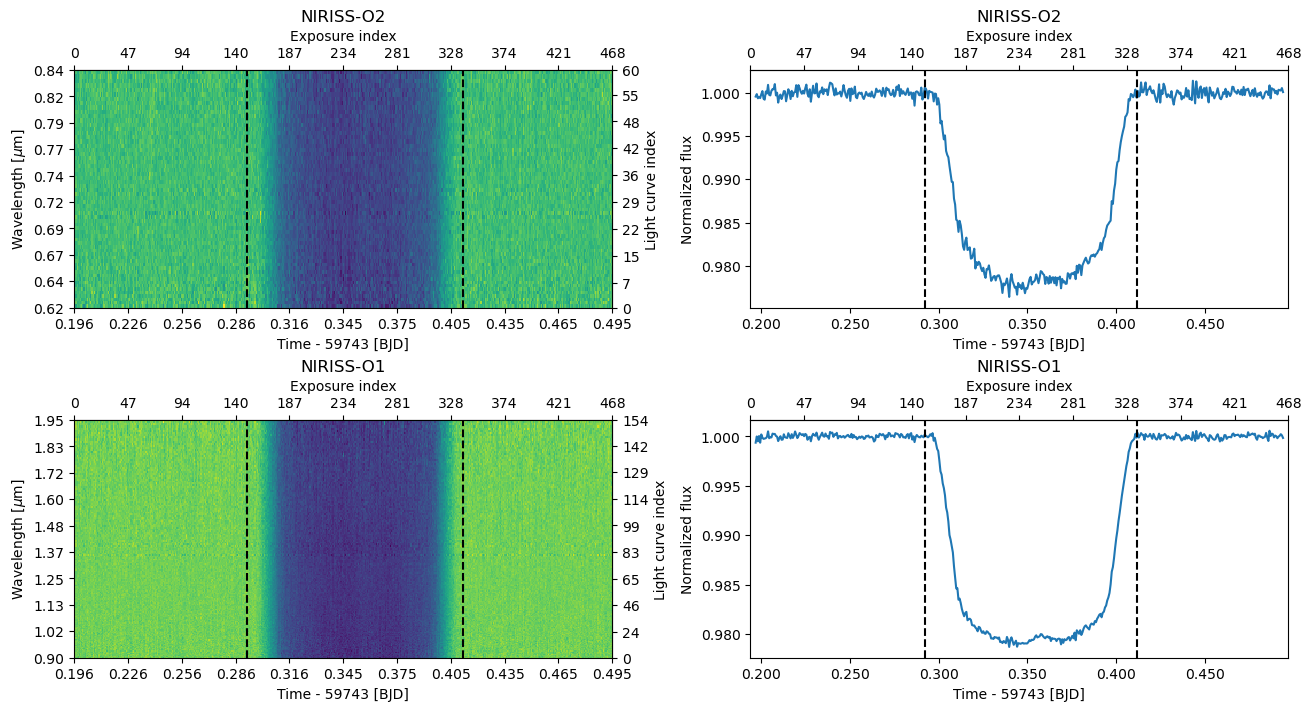

In [19]:
fig, axs = subplots(2, 2, figsize=(13, 7), constrained_layout=True)
d.plot(axs=axs[:,0])
d.plot_white(axs=axs[:,1]);

## Setting Up the Model with TLSE

We initialize ExoIris as usual, then enable TLSE when initializing the spot model.

In [20]:
ts = ExoIris('07_tlse_example', 'power-2', d, nk=50, nthreads=1)
ts.set_prior('tc_00', 'NP', ephemeris.zero_epoch, 0.003)
ts.set_prior('p', 'NP', ephemeris.period, 1e-7)
ts.set_prior('rho', 'NP', 2.68, 0.2)
ts.set_prior('radius ratios', 'UP', 0.125, 0.145)
ts.set_ldtk_prior((4790, 120), (4.58, 0.01), (0.14, 0.1), uncertainty_multiplier=10)

### Enable TLSE

The key step is setting `include_tlse=True` when initializing the spot model. This adds the TLSE parameters to the model even if you don't add any spot crossings. Here, we however add the spot that we knot already from Tutorial 6.

In [21]:
ts.initialize_spots(tstar=4790, wlref=1.5, include_tlse=True)
ts.add_spot(epoch_group=0)

### TLSE Parameters

Let's examine the TLSE parameters that have been added:

In [22]:
tlse_params = [p for p in ts.ps if 'tlse' in p.name]
for p in tlse_params:
    print(p)

 77 |G| tlse_tspot     U(a = 1200, b = 7000)                    [ 1200.00 ..  7000.00]
 78 |G| tlse_tfac      U(a = 1200, b = 7000)                    [ 1200.00 ..  7000.00]
 79 |G| tlse_aspot_e00 U(a = 0, b = 1)                          [    0.00 ..     1.00]
 80 |G| tlse_afac_e00  U(a = 0, b = 1)                          [    0.00 ..     1.00]


The TLSE parameters are:

| Parameter | Description | Typical Prior |
|-----------|-------------|---------------|
| `tlse_tspot` | Effective temperature of unocculted spots (K) | Normal, centered ~500 K below T$_{\rm eff}$ |
| `tlse_tfac` | Effective temperature of unocculted faculae (K) | Normal, centered ~100-300 K above T$_{\rm eff}$ |
| `tlse_aspot_eXX` | Area fraction covered by spots (per epoch) | Uniform [0, 0.3-0.5] |
| `tlse_afac_eXX` | Area fraction covered by faculae (per epoch) | Uniform [0, 0.3-0.5] |

**Note:** The area fractions are defined *per epoch* because stellar activity can change between observations. If you have multiple transits, each epoch group will have its own `aspot` and `afac` parameters.

### Setting TLSE Priors

Setting appropriate priors for TLSE parameters requires some thought:

**Temperature priors:**
- Spot temperatures are typically 500-1500 K cooler than the photosphere
- Faculae temperatures are typically 100-300 K hotter than the photosphere
- Use normal priors centered on expected values with reasonable widths

**Area fraction priors:**
- For active stars: spot coverage can be 5-30%
- For quiet stars: spot coverage is typically <5%
- Faculae coverage is often similar to or larger than spot coverage
- Use uniform priors allowing exploration of the relevant range

In [23]:
ts.set_prior('tlse_tspot', 'NP', 4290, 200)
ts.set_prior('tlse_tfac', 'NP', 4890, 100)
ts.set_prior('tlse_aspot_e00', 'UP', 0.0, 0.4)
ts.set_prior('tlse_afac_e00', 'UP', 0.0, 0.4)

Also set priors for the spot crossing (same as Tutorial 6).

In [24]:
ts.set_prior('spc_01', 'NP', 59743.355, 0.001)
ts.set_prior('spa_01', 'UP', 0.0, 0.002)
ts.set_prior('spw_01', 'UP', 0.001, 0.05)
ts.set_prior('spt_01', 'UP', 3850, 4790)

In [25]:
# Show all spot and TLSE parameters
ts.ps[-10:]

[ 76 |G| sigma_m_00     N(μ = 1.0, σ = 0.01)                     [    0.00 ..      inf],
  77 |G| tlse_tspot     N(μ = 4290.0, σ = 200.0)                 [ 1200.00 ..  7000.00],
  78 |G| tlse_tfac      N(μ = 4890.0, σ = 100.0)                 [ 1200.00 ..  7000.00],
  79 |G| tlse_aspot_e00 U(a = 0.0, b = 0.4)                      [    0.00 ..     1.00],
  80 |G| tlse_afac_e00  U(a = 0.0, b = 0.4)                      [    0.00 ..     1.00],
  81 |G| spc_01         N(μ = 59743.355, σ = 0.001)              [    0.00 ..      inf],
  82 |G| spa_01         U(a = 0.0, b = 0.002)                    [    0.00 ..      inf],
  83 |G| spw_01         U(a = 0.001, b = 0.05)                   [    0.00 ..      inf],
  84 |G| sps_01         U(a = 1, b = 5)                          [    0.00 ..      inf],
  85 |G| spt_01         U(a = 3850, b = 4790)                    [    0.00 ..      inf]]

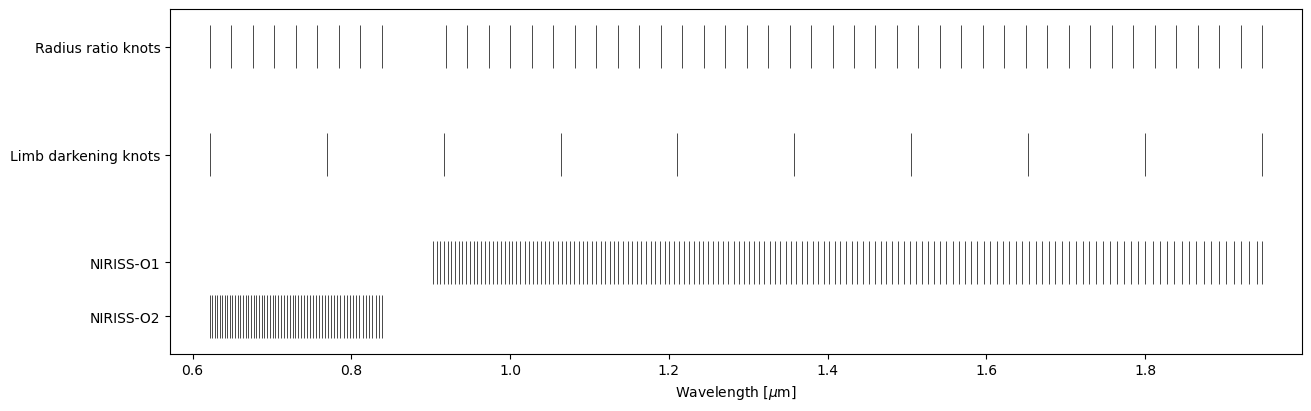

In [26]:
knots = ts.k_knots.copy()
m = (knots > ts.data[0].bbox_wl[1]) & (knots < ts.data[1].bbox_wl[0])
ts.set_radius_ratio_knots(knots[~m])

ts.plot_setup(figsize=(13, 4));

## Fitting the Model

The fitting workflow is identical to the standard ExoIris workflow.

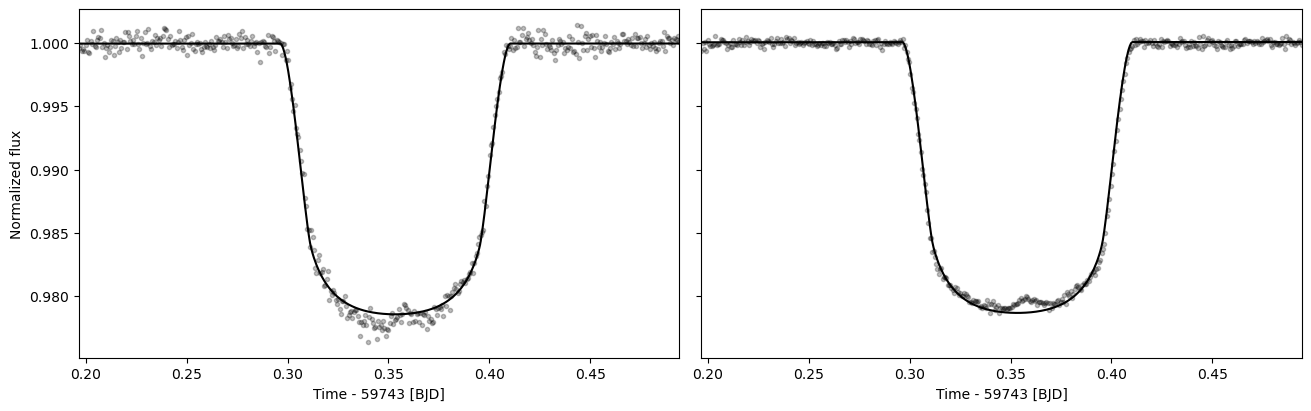

In [27]:
ts.fit_white()
ts.plot_white(figsize=(13, 4));

In [28]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/5000 [00:00<?, ?it/s]

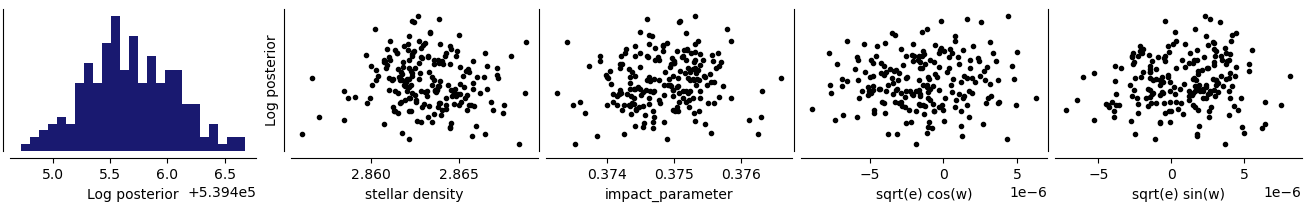

In [29]:
ts.fit(niter=5000, npop=200, pool=pool, lnpost=lnpostf)

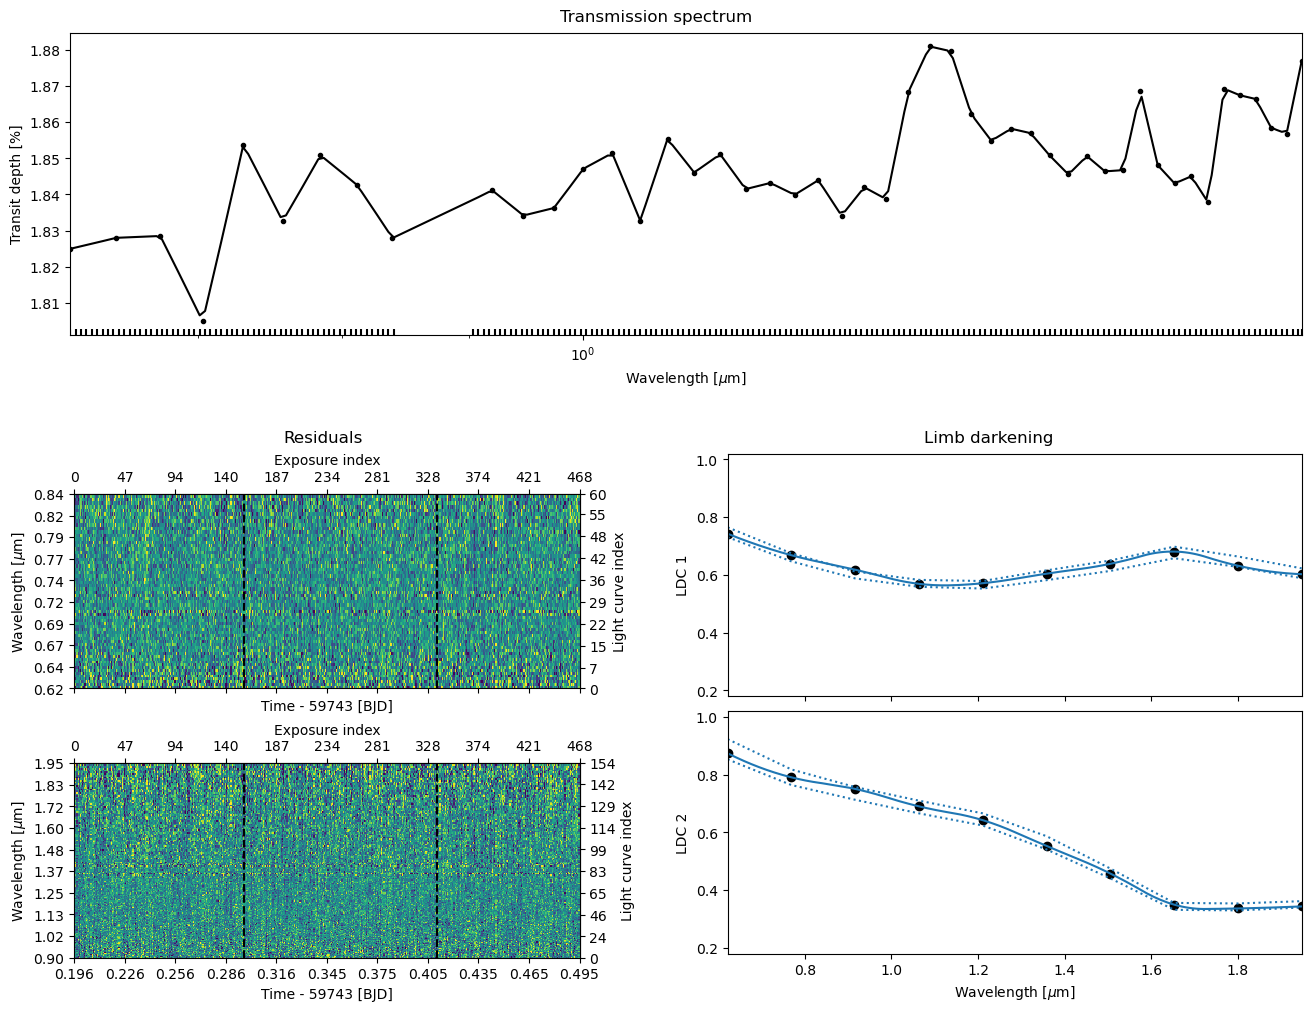

In [30]:
ts.plot_fit(figsize=(13, 10), height_ratios=(1, 1.5), trs_args={'xscale': 'log'});

## MCMC Sampling

In [31]:
ts.sample(1000, thin=50, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

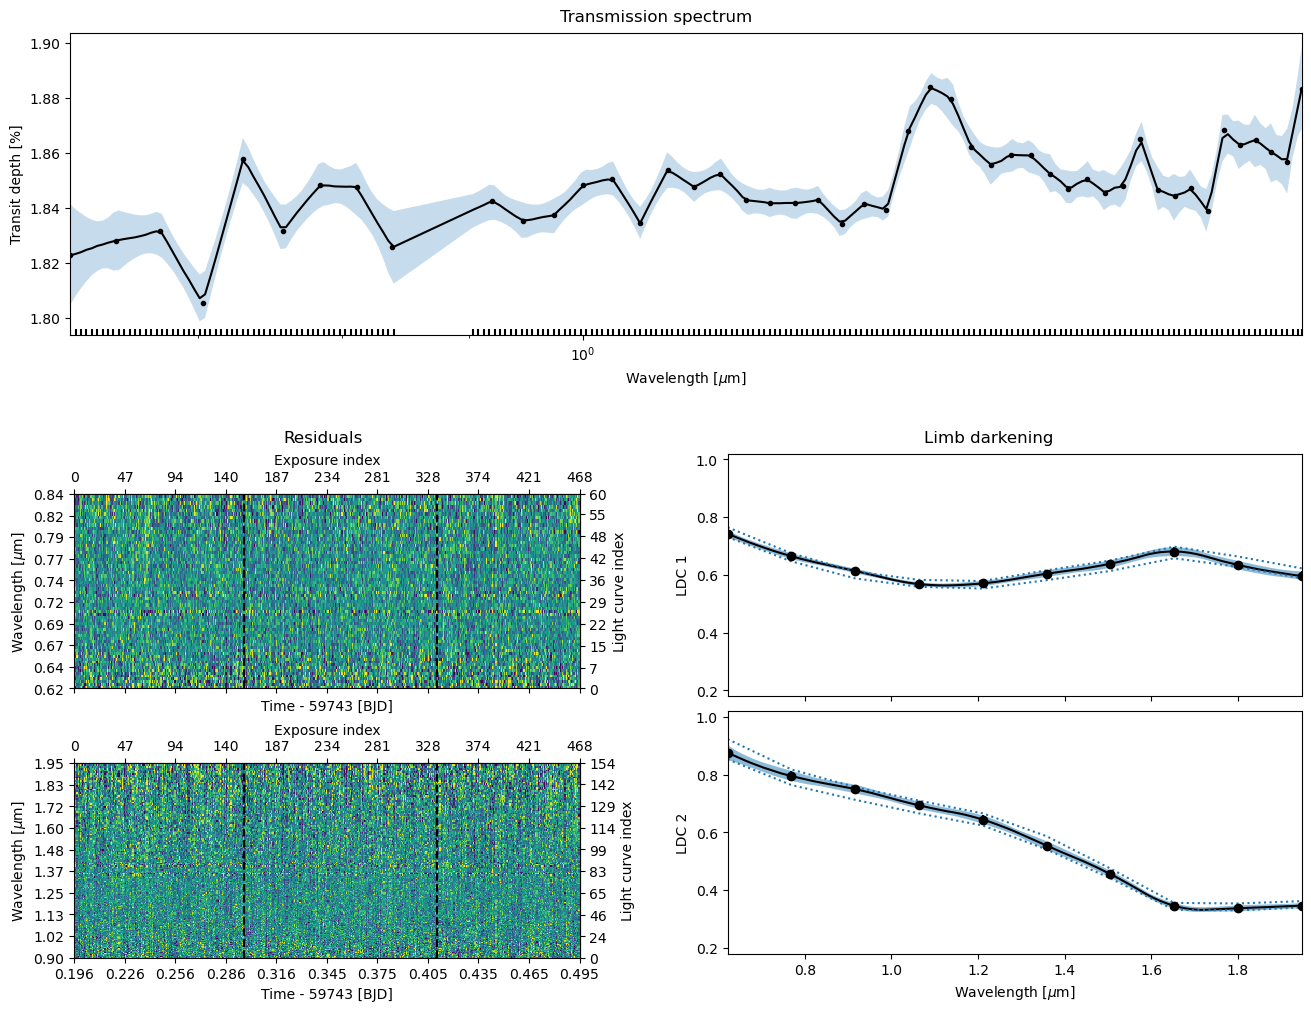

In [32]:
ts.plot_fit('mcmc', figsize=(13, 10), height_ratios=(1, 1.5), trs_args={'xscale': 'log'});

## Interpreting TLSE Results

Let's examine the posterior distributions for the TLSE parameters.

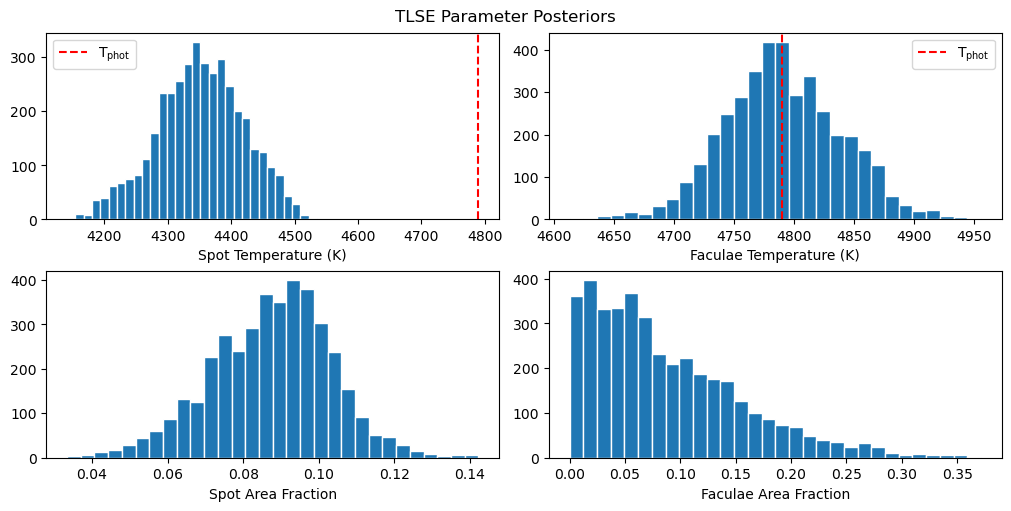

In [38]:
tlse_cols = [c for c in ts.posterior_samples.columns if 'tlse' in c]

fig, axs = subplots(2, 2, figsize=(10, 5), constrained_layout=True)

axs[0,0].hist(ts.posterior_samples['tlse_tspot'], bins=30, edgecolor='white')
axs[0,0].axvline(4790, color='red', ls='--', label='T$_{\\rm phot}$')
axs[0,0].set_xlabel('Spot Temperature (K)')
axs[0,0].legend()

axs[0,1].hist(ts.posterior_samples['tlse_tfac'], bins=30, edgecolor='white')
axs[0,1].axvline(4790, color='red', ls='--', label='T$_{\\rm phot}$')
axs[0,1].set_xlabel('Faculae Temperature (K)')
axs[0,1].legend()

axs[1,0].hist(ts.posterior_samples['tlse_aspot_e00'], bins=30, edgecolor='white')
axs[1,0].set_xlabel('Spot Area Fraction')

axs[1,1].hist(ts.posterior_samples['tlse_afac_e00'], bins=30, edgecolor='white')
axs[1,1].set_xlabel('Faculae Area Fraction')

fig.suptitle('TLSE Parameter Posteriors');

### Interpretation Guidelines

**Area fractions consistent with zero:** If the posteriors for `tlse_aspot` and `tlse_afac` are peaked near zero, the data don't require significant TLSE correction. This could mean:
- The star has low spot/faculae coverage
- The effect is below your measurement precision
- The spots/faculae are uniformly distributed (no net effect)

**Non-zero area fractions:** If the posteriors show significant coverage:
- The transmission spectrum has been corrected for TLSE
- Without this correction, the spectrum would be biased
- Consider whether the inferred coverage is physically reasonable

**Temperature posteriors:** 
- Spot temperatures should be cooler than T$_{\rm eff}$
- Faculae temperatures should be hotter than T$_{\rm eff}$
- If posteriors hit the prior bounds, consider widening your priors

### TLSE-Corrected Transmission Spectrum

The transmission spectrum from ExoIris is automatically corrected for TLSE when the model is included.

In [42]:
ts_no_tlse = load_model('06_spot_crossing.fits')

(1.8, 1.92)

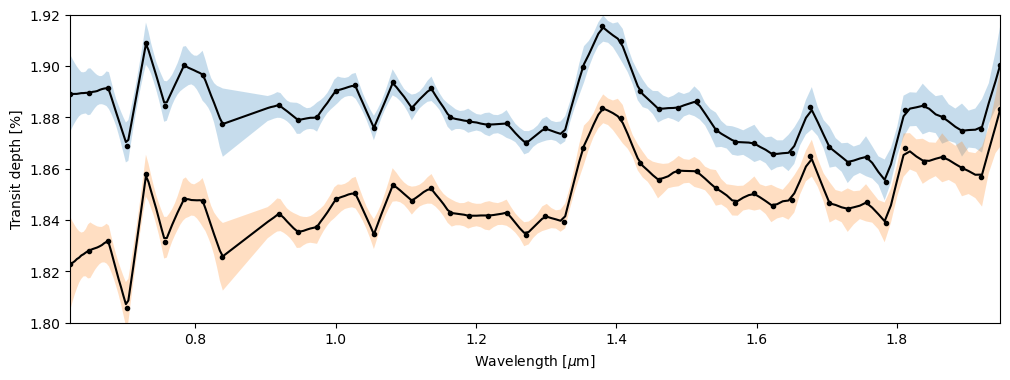

In [55]:
fig, ax = subplots()
ts_no_tlse.plot_transmission_spectrum('mcmc', ax=ax, plot_resolution=False);
ts.plot_transmission_spectrum('mcmc', ax=ax, plot_resolution=False);
ax.set_ylim(1.8, 1.92)

## TLSE with Multiple Epochs

When analyzing multiple transits, TLSE becomes even more important because:

1. **Spot coverage varies over time** due to stellar rotation and activity cycles
2. **Each epoch gets its own area fraction parameters** (`tlse_aspot_e00`, `tlse_aspot_e01`, etc.)
3. **Temperature parameters are shared** across epochs (assuming spots have similar properties)

This allows the model to account for different levels of stellar contamination at different epochs while maintaining physical consistency.

## Using TLSE Without Spot Crossings

You can enable TLSE even if you don't observe any spot crossings. Simply call `initialize_spots()` with `include_tlse=True` but don't call `add_spot()`:

```python
# TLSE only, no spot crossings
ts.initialize_spots(tstar=4790, wlref=1.5, include_tlse=True)
# Don't call ts.add_spot() - only TLSE parameters will be added
```

This is useful when:
- The light curve shows no obvious spot crossing bumps
- But you know the star is active (e.g., from rotational modulation)
- You want to marginalize over possible stellar contamination

## Save and Cleanup

In [56]:
ts.save(overwrite=True)

In [57]:
pool.close()

---

<center>&copy;2026 Hannu Parviainen</center>